# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://iie.fing.edu.uy/~jlezama/DLVIS2020/entregables.html) on the course website.*

In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time
np.random.seed(1)
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.379474
sanity check: 2.302585


**Inline Question 1**

- 1.1 Why do we expect our loss to be close to -log(0.1)? Explain briefly.
- 1.2 What are the minimum and maximum possible value for the Softmax loss? 

$\color{blue}{\textit Your Answer:}$ 

- 1.1 Debido a que $W$ es una matriz aleatoria, y esto lleva a que la etiqueta que se le asigne a cada imagen sera aleatoria, teniendo aproximadamente las mismas chances todas las clases. Como tenemos 10 clases, la probabilidad sera cercana a $0.1$, entonces por la formula de la perdida de softmax se tiene que la loss sera cercana a $-log(0.1)$.

- 1.2 El valor minimo es $0$, esto se da cuando todas las etiquetas se asignan correctamente con probabilidad $1$. El valor maximo no esta acotado, si se asignara probabilidades cercanas a 0 a la clase correcta se tendra una loss muy grande.



In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.975788 analytic: -0.975788, relative error: 2.022532e-08
numerical: -0.295596 analytic: -0.295596, relative error: 7.027959e-08
numerical: 0.611099 analytic: 0.611099, relative error: 1.315115e-07
numerical: -0.218349 analytic: -0.218349, relative error: 1.369570e-07
numerical: -0.455568 analytic: -0.455568, relative error: 1.274088e-07
numerical: -1.189839 analytic: -1.189839, relative error: 5.927065e-09
numerical: -0.768177 analytic: -0.768177, relative error: 2.476633e-08
numerical: 3.928197 analytic: 3.928197, relative error: 1.941423e-09
numerical: 0.677757 analytic: 0.677757, relative error: 1.782695e-08
numerical: -0.991828 analytic: -0.991828, relative error: 5.471421e-09
numerical: -1.377222 analytic: -1.377222, relative error: 3.878276e-09
numerical: 1.015120 analytic: 1.015120, relative error: 6.514838e-08
numerical: -1.903151 analytic: -1.903151, relative error: 9.520405e-10
numerical: 3.064891 analytic: 3.064891, relative error: 1.940001e-08
numerical: -0.90

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# W e use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.379474e+00 computed in 0.065679s
vectorized loss: 2.379474e+00 computed in 0.007456s
Loss difference: 0.000000
Gradient difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [7]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 1554.577437
iteration 100 / 1500: loss 209.369690
iteration 200 / 1500: loss 29.802263
iteration 300 / 1500: loss 5.851015
iteration 400 / 1500: loss 2.625836
iteration 500 / 1500: loss 2.167601
iteration 600 / 1500: loss 2.111192
iteration 700 / 1500: loss 2.137756
iteration 800 / 1500: loss 2.134776
iteration 900 / 1500: loss 2.112847
iteration 1000 / 1500: loss 2.141195
iteration 1100 / 1500: loss 2.106202
iteration 1200 / 1500: loss 2.191875
iteration 1300 / 1500: loss 2.147869
iteration 1400 / 1500: loss 2.135703
That took 5.565455s


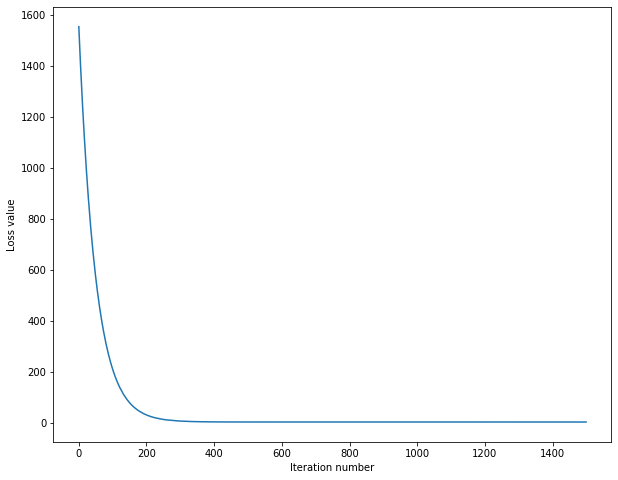

In [8]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [9]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
print( 'training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print( 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.303857
validation accuracy: 0.319000


In [52]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save  the best trained softmax classifer in best_softmax.                    #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 1e-6, 1e-5, 1e-4]
regularization_strengths = [2.0e4, 4e4, 1e3, 1e2, 1e1]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
acc = list()
best_val = -1
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=False)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        acc_train = np.mean(y_train == y_train_pred)
        acc_val = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (acc_train, acc_val)
        
        if acc_val>best_val:
            best_softmax =  softmax
            best_val = acc_val
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e+01 train accuracy: 0.301714 val accuracy: 0.313000
lr 1.000000e-07 reg 1.000000e+02 train accuracy: 0.305408 val accuracy: 0.323000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.302184 val accuracy: 0.320000
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.305102 val accuracy: 0.320000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.303796 val accuracy: 0.323000
lr 1.000000e-06 reg 1.000000e+01 train accuracy: 0.304531 val accuracy: 0.321000
lr 1.000000e-06 reg 1.000000e+02 train accuracy: 0.307878 val accuracy: 0.320000
lr 1.000000e-06 reg 1.000000e+03 train accuracy: 0.300000 val accuracy: 0.318000
lr 1.000000e-06 reg 2.000000e+04 train accuracy: 0.306755 val accuracy: 0.320000
lr 1.000000e-06 reg 4.000000e+04 train accuracy: 0.305082 val accuracy: 0.319000
lr 1.000000e-05 reg 1.000000e+01 train accuracy: 0.301857 val accuracy: 0.323000
lr 1.000000e-05 reg 1.000000e+02 train accuracy: 0.312204 val accuracy: 0.320000
lr 1.000000e-05 reg 1.000000

In [51]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.325000


**Inline Question 2** - *Softmax loss with Temperature*

Suppose we want to use a temperature parameter $T$ for the softmax distribution: 
$$P(i) = \frac{e^{\frac{f_i}{T}}}{\sum_j e^{\frac{f_j}{T}}} $$
where $f_i$ is the score for class $i$
- What values of $T$ would make the model more confident about its predictions?
- How would it affect the training process? You may test this experimentally.


$\color{blue}{\textit Your Answer:}$

1. Valores de $T<1$ generan **mayor** seguridad.
2. Valores de $T>1$ generan **mayor** seguridad



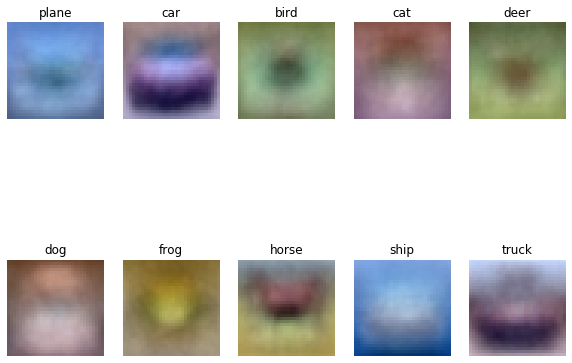

In [49]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])